In [ ]:
!pip install qpsolvers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 1.6 MB/s 


# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from qpsolvers import solve_qp

# Helpers + Classes

In [1]:
class MySVM:

  def __init__(self, C=1.0, gamma=1.0, kernel_type='linear'):
    self.C = C
    self.gamma = gamma
    self.kernel_type = kernel_type

  def kernel(self, X1, X2, c=0.0, d=1.0):
    if self.kernel_type == 'linear':
      return np.dot(np.transpose(X1), X2) + c 
    elif self.kernel_type == 'polynomial':
      return (np.dot(X1, np.transpose(X2)) + c) ^ d 
    elif self.kernel_type == 'rbf':
      if self.gamma == None:
        self.gamma = 1 / X1.shape[-1]  # 1 / D
      if (X1.ndim == 1) and (X2.ndim == 1):
        return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
      elif ((X1.ndim > 1) and (X2.ndim == 1)) or ((X1.ndim == 1) and (X2.ndim > 1)):
        return np.exp(-self.gamma * np.linalg.norm(X1- X2, axis=1) ** 2)
      elif (X1.ndim > 1) and (X2.ndim > 1):
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
    elif self.kernel_type == 'sigmoid':
      return np.tanh(self.gamma * np.dot(X1, np.transpose(X2)) + c)

  def dualQP_fit(self):
    self.yI = np.zeros((2*(self.N_train + 1), self.N_train))
    self.yI[0, :] = self.y_train
    self.yI[1, :] = -self.y_train
    self.yI[2:self.N_train+2, :] = -np.identity(self.N_train)
    self.yI[self.N_train+2:, :] = np.identity(self.N_train)

    self.C0 = np.zeros(2*(self.N_train + 1))
    self.C0[self.N_train+2:] = self.C

    self.K = self.kernel(self.X_train, self.X_train)
    self.yy = np.outer(self.y_train, self.y_train)
    self.yyX = np.multiply(self.yy, self.K)

    self.alphas = solve_qp(self.yyX, -np.ones((self.N_train, 1)), self.yI, self.C0, solver=self.qp_solver)
    self.w = np.dot(np.transpose(self.X_train), np.multiply(self.alphas, self.y_train))  
    self.b = np.mean(self.y_train - np.dot(self.X_train, self.w))

  def dualGD_fit(self):
    self.K = self.kernel(self.X_train, self.X_train)
    self.yy = np.outer(self.y_train, self.y_train)
    self.yyX = np.multiply(self.yy, self.K)
    self.alphas = np.random.random(self.N_train)

    losses = list()
    for n_iter in range(self.n_iters):
      loss = np.sum(self.alphas) - 0.5 * np.dot(np.dot(np.transpose(self.alphas), self.yyX), self.alphas) 
      losses.append(loss)
      grad = np.ones(self.N_train) - np.dot(self.yyX, self.alphas)
      self.alphas += self.lr * grad
      self.alphas[self.alphas < 0] = 0
      self.alphas[self.alphas > self.C] = self.C

    self.w = np.dot(np.transpose(self.X_train), np.multiply(self.alphas, self.y_train))  
    self.b = np.mean(self.y_train - np.dot(self.X_train, self.w))

  def primalGD_fit(self):
    self.K = self.kernel(self.X_train, self.X_train)
    self.w = np.random.randn(self.N_train)
    self.b = 0

    losses = list()
    for n_iter in range(self.n_iters):
      margins = self.y_train * (np.dot(self.w, self.K) + self.b)
      loss = 0.5 * np.dot(self.w, np.dot(self.K, self.w)) + self.C * np.maximum(0, 1 - margins).sum()
      losses.append(loss)
      indexes = np.where(margins < 1)[0]
      grad_w = np.dot(self.K, self.w) - self.C * np.dot(self.y_train[indexes], self.K[indexes])
      grad_b = - self.C * np.sum(self.y_train[indexes])
      self.w -= self.lr * grad_w
      self.b -= self.lr * grad_b

  def fit(self, X, y, lr=None, n_iters=None, method=None, qp_solver='osqp'):
    self.X_train = X
    self.y_train = y
    self.lr = lr
    self.n_iters = n_iters
    self.method = method
    self.qp_solver = qp_solver
    self.N_train = self.X_train.shape[0]
    
    if self.method == 'dual_with_QP':
      self.dualQP_fit()
    elif self.method == 'dual_with_GD':
      self.dualGD_fit()
    elif self.method == 'primal_with_GD':
      self.primalGD_fit()
    # elif self.method == 'dual_with_semi_vectorized_GD':
    #   self.dualGD_semi_vectorized_fit()

  def predict(self, X):
    if (self.method == 'dual_with_QP') or (self.method == 'dual_with_GD'): # or (self.method == 'dual_with_semi_vectorized_GD'):
      return np.sign(np.dot(np.multiply(self.alphas, self.y_train), self.kernel(self.X_train, X)) + self.b)
    elif self.method == 'primal_with_GD':
      return np.sign(np.dot(self.w, self.kernel(self.X_train, X)) + self.b)
    else:
      print("No method was used during training")

  def get_accuracy(self, y1, y2):
    return 100 * np.mean(y1 == y2)

  def plot_decision_boundary(self, X, y):
    if X.shape[1] == 2:
      x1_line = np.arange(0, 1, 0.01)
      x2_line = (- self.w[0] / self.w[1]) * x1_line - self.b / self.w[1]

      pos_pos = np.where(y == 1)
      neg_pos = np.where(y == -1)

      plt.figure(figsize=(30, 10))
      plt.scatter(X[pos_pos, 0], X[pos_pos, 1], c='b')
      plt.scatter(X[neg_pos, 0], X[neg_pos, 1], c='r')
      plt.plot(x1_line, x2_line, c='g')
      plt.show()
    else:
      print("The data to be plotted has dimensionality higher than 2")

In [ ]:
# def dualGD_semi_vectorized_fit(self):

#   self.alphas = np.random.random(self.N_train)
#   losses = list()
#   for n_iter in range(self.n_iters):
#     print(f"*Epoch {n_iter}*")
#     for i in range(self.X_train.shape[0]):
#       x_train = self.X_train[i, :]
#       y_i = y_train[i]
#       K = self.kernel(self.X_train, x_train)
#       yy = y_i * self.y_train
#       yyX = np.multiply(yy, K)       
#       # loss = np.sum(self.alphas) - 0.5 * np.dot(np.dot(np.transpose(self.alphas), yyX), self.alphas) 
#       # losses.append(loss)
#       # grad = np.ones(self.N_train) - np.dot(yyX, self.alphas)
#       grad = 1 - np.dot(yyX, self.alphas)
#       self.alphas[i] += self.lr * grad
#       if self.alphas[i] < 0:
#         self.alphas[i] = 0 
#       if self.alphas[i] > self.C:
#         self.alphas[i] = self.C 

#   self.w = np.dot(np.transpose(self.X_train), np.multiply(self.alphas, self.y_train))  
#   self.b = np.mean(self.y_train - np.dot(self.X_train, self.w))

In [ ]:
def create_data(N, a=3, b=1):
  N = int(N)
  x1_pos = a + np.random.randn(int(N/2))
  x2_pos = b + np.random.randn(int(N/2))
  x1_neg = -a + np.random.randn(int(N/2))
  x2_neg = -b + np.random.randn(int(N/2))

  return x1_pos, x2_pos, x1_neg, x2_neg

def plot_data(x1_pos, x2_pos, x1_neg, x2_neg):
  plt.figure(figsize=(30, 10))
  plt.scatter(x1_pos, x2_pos, c='b')
  plt.scatter(x1_neg, x2_neg, c='r')
  plt.title('Linearly separable data - 2D')
  plt.xlabel('x1')
  plt.ylabel('x2')
  
def split_and_scale(x1_pos, x2_pos, x1_neg, x2_neg):
  N = len(x1_pos) + len(x2_pos)
  X = np.zeros((N, 2))
  X[:len(x1_pos), 0] = x1_pos
  X[:len(x2_pos), 1] = x2_pos
  X[len(x1_pos):, 0] = x1_neg
  X[len(x2_pos):, 1] = x2_neg

  y = np.concatenate((np.ones(int(N/2)), -np.ones(int(N/2))))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_test_scaled, y_train, y_test

# Main

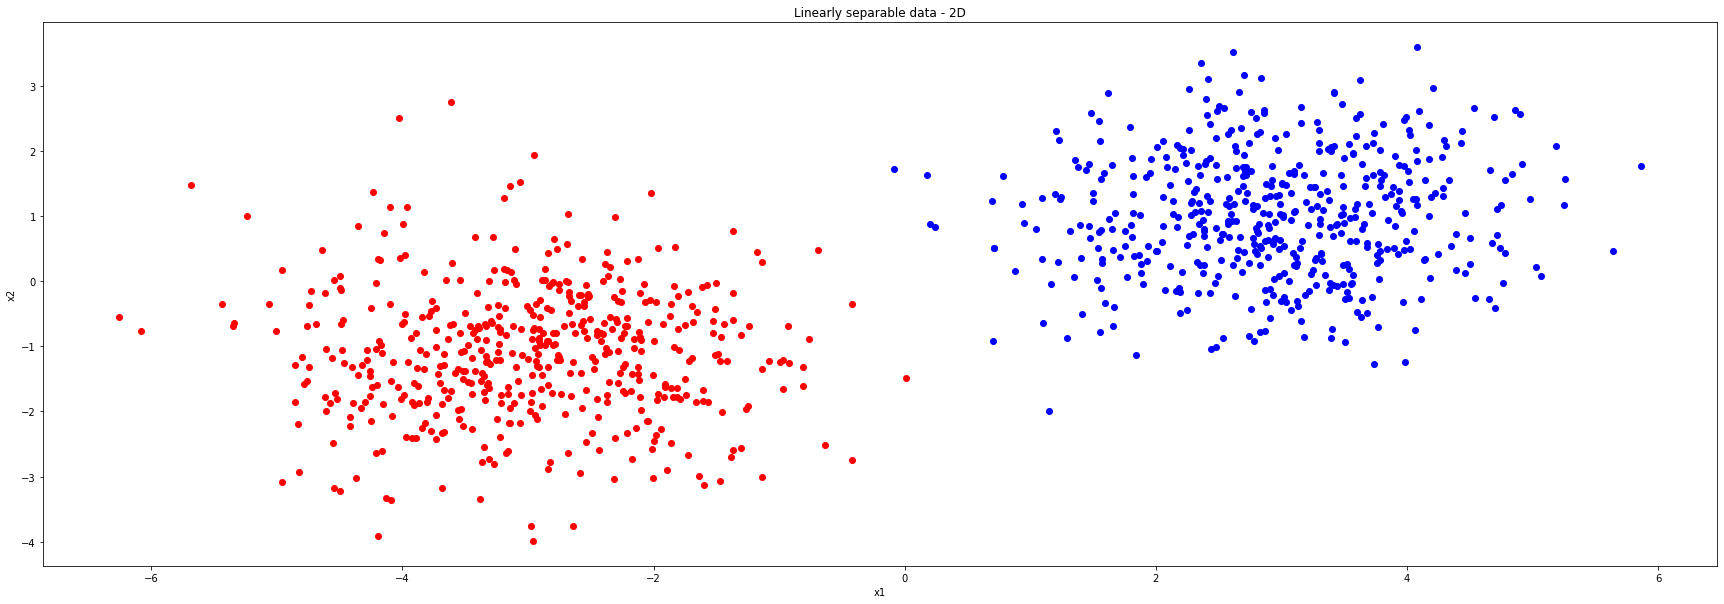

In [ ]:
np.random.seed(7)
N = 1000
x1_pos, x2_pos, x1_neg, x2_neg = create_data(N)
plot_data(x1_pos, x2_pos, x1_neg, x2_neg)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(x1_pos, x2_pos, x1_neg, x2_neg)

In [ ]:
# 1. Using the QP solver
my_svm = MySVM(C=1.0, kernel_type='linear')
my_svm.fit(X_train_scaled, y_train, method='dual_with_QP')
y_preds = my_svm.predict(X_test_scaled)
print(f"\nTest Accuracy = {my_svm.get_accuracy(y_test, y_preds)}\n")
my_svm.plot_decision_boundary(X_test_scaled, y_test)

/usr/local/lib/python3.8/dist-packages/qpsolvers/solvers/conversions/warnings.py:34: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/qpsolvers/solvers/conversions/warnings.py:34: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(



Test Accuracy = 100.0



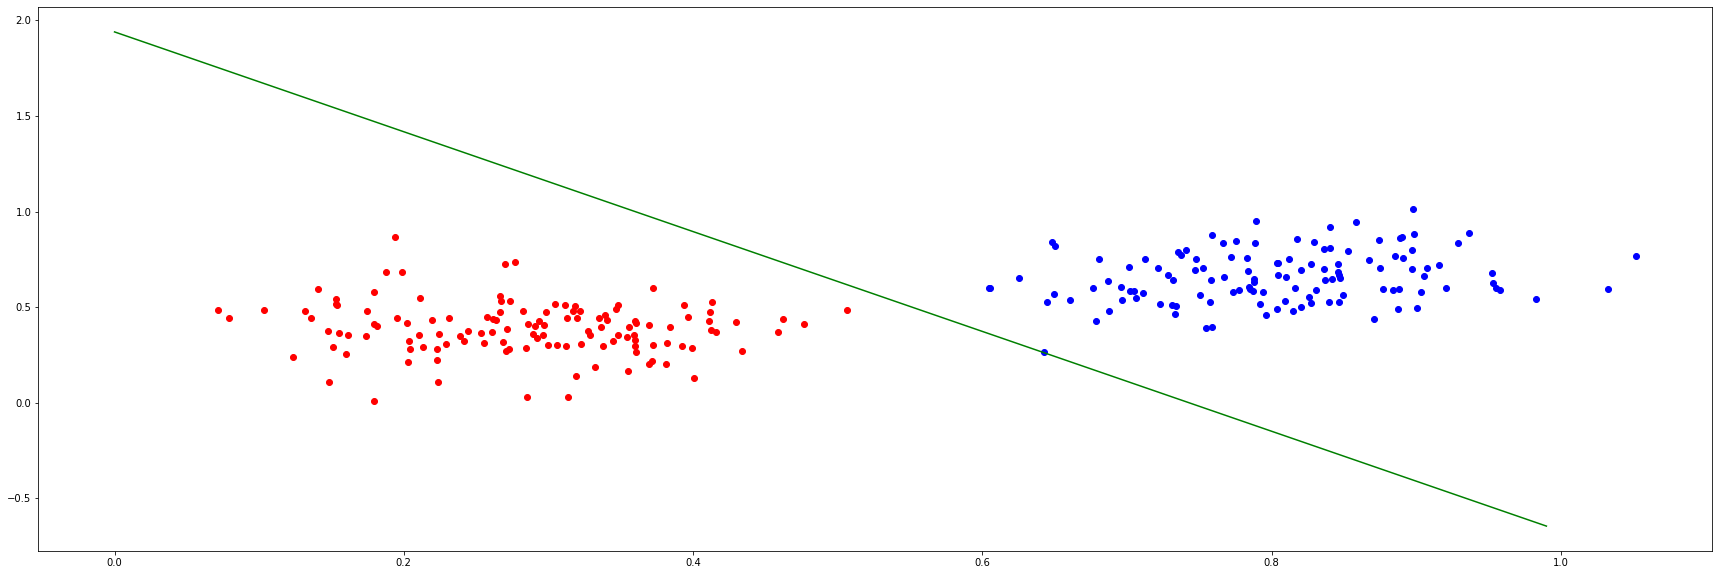


Test Accuracy = 99.6



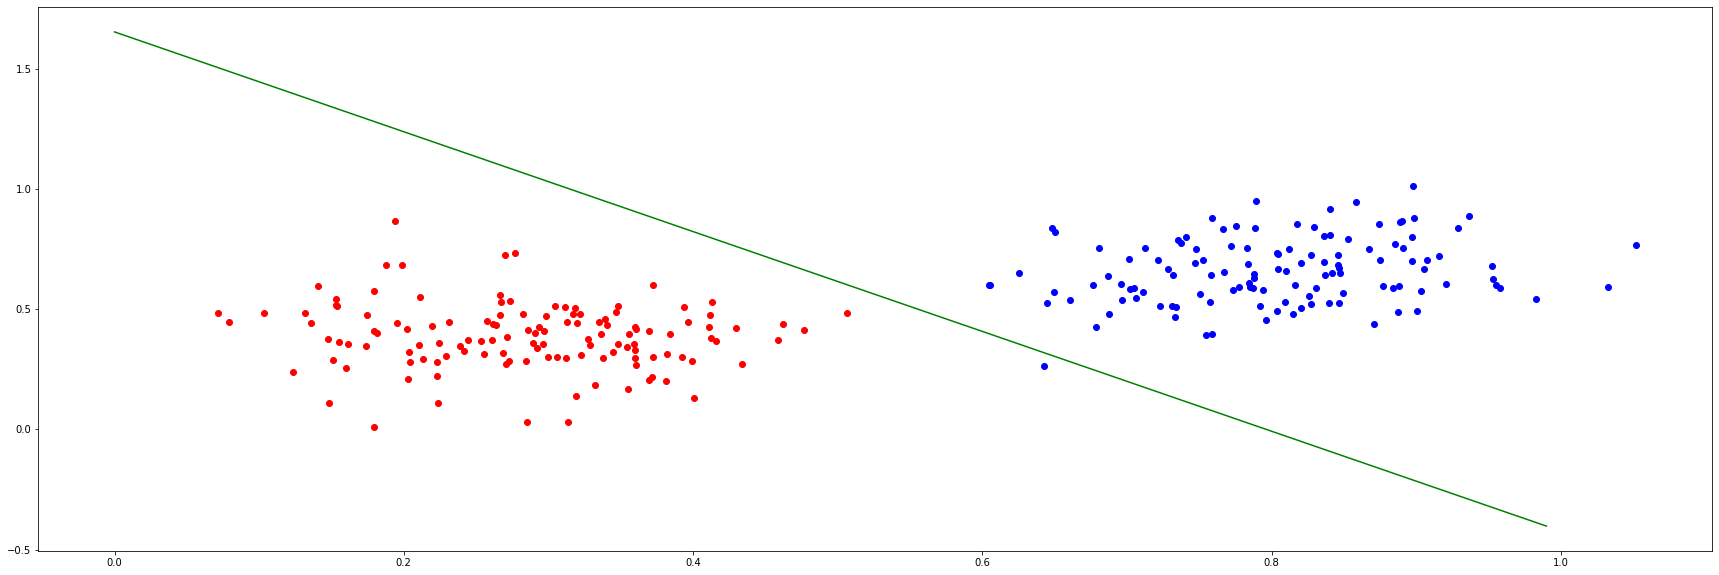

In [ ]:
# 2. Using the solution that GD gives for the DUAL problem
my_svm = MySVM(C=1.0, kernel_type='linear')
my_svm.fit(X_train_scaled, y_train, method='dual_with_GD', lr = 1e-5, n_iters=50)
y_preds = my_svm.predict(X_test_scaled)
print(f"\nTest Accuracy = {my_svm.get_accuracy(y_test, y_preds)}\n")
my_svm.plot_decision_boundary(X_test_scaled, y_test)

In [ ]:
# 3. Using the solution that GD gives for the PRIMAL problem
best_test_accuracy = 50. 
for C in [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3]:
  my_svm = MySVM(C=C, kernel_type='linear')
  for lr in [1e-3, 1e-4, 1e-5]:
    for n_iters in np.arange(5, 101, 5):
      print(f"*C = {C}, lr = {lr}, N_iters = {n_iters}*")
      my_svm.fit(X_train_scaled, y_train, method='primal_with_GD', lr=lr, n_iters=n_iters)
      y_preds = my_svm.predict(X_test_scaled)
      current_test_accuracy = my_svm.get_accuracy(y_test, y_preds)
      print(f"Test Accuracy = {current_test_accuracy}\n")
      if current_test_accuracy > best_test_accuracy:
        best_test_accuracy = current_test_accuracy
        best_C, best_lr, best_n_iters = C, lr, n_iters
        best_model, best_y_preds = my_svm, y_preds

*C = 0.0001, lr = 0.001, N_iters = 5*
Test Accuracy = 51.2

*C = 0.0001, lr = 0.001, N_iters = 10*
Test Accuracy = 76.0

*C = 0.0001, lr = 0.001, N_iters = 15*
Test Accuracy = 76.8

*C = 0.0001, lr = 0.001, N_iters = 20*
Test Accuracy = 76.8

*C = 0.0001, lr = 0.001, N_iters = 25*
Test Accuracy = 25.6

*C = 0.0001, lr = 0.001, N_iters = 30*
Test Accuracy = 24.4

*C = 0.0001, lr = 0.001, N_iters = 35*
Test Accuracy = 24.4

*C = 0.0001, lr = 0.001, N_iters = 40*
Test Accuracy = 76.8

*C = 0.0001, lr = 0.001, N_iters = 45*
Test Accuracy = 76.8

*C = 0.0001, lr = 0.001, N_iters = 50*
Test Accuracy = 37.2

*C = 0.0001, lr = 0.001, N_iters = 55*
Test Accuracy = 31.2

*C = 0.0001, lr = 0.001, N_iters = 60*
Test Accuracy = 77.60000000000001

*C = 0.0001, lr = 0.001, N_iters = 65*
Test Accuracy = 74.8

*C = 0.0001, lr = 0.001, N_iters = 70*
Test Accuracy = 25.6

*C = 0.0001, lr = 0.001, N_iters = 75*
Test Accuracy = 76.0

*C = 0.0001, lr = 0.001, N_iters = 80*
Test Accuracy = 25.2

*C = 0.0001,

In [ ]:
print(best_test_accuracy, best_C, best_lr, best_n_iters)

99.6 10 1e-05 85


Test Accuracy = 99.6



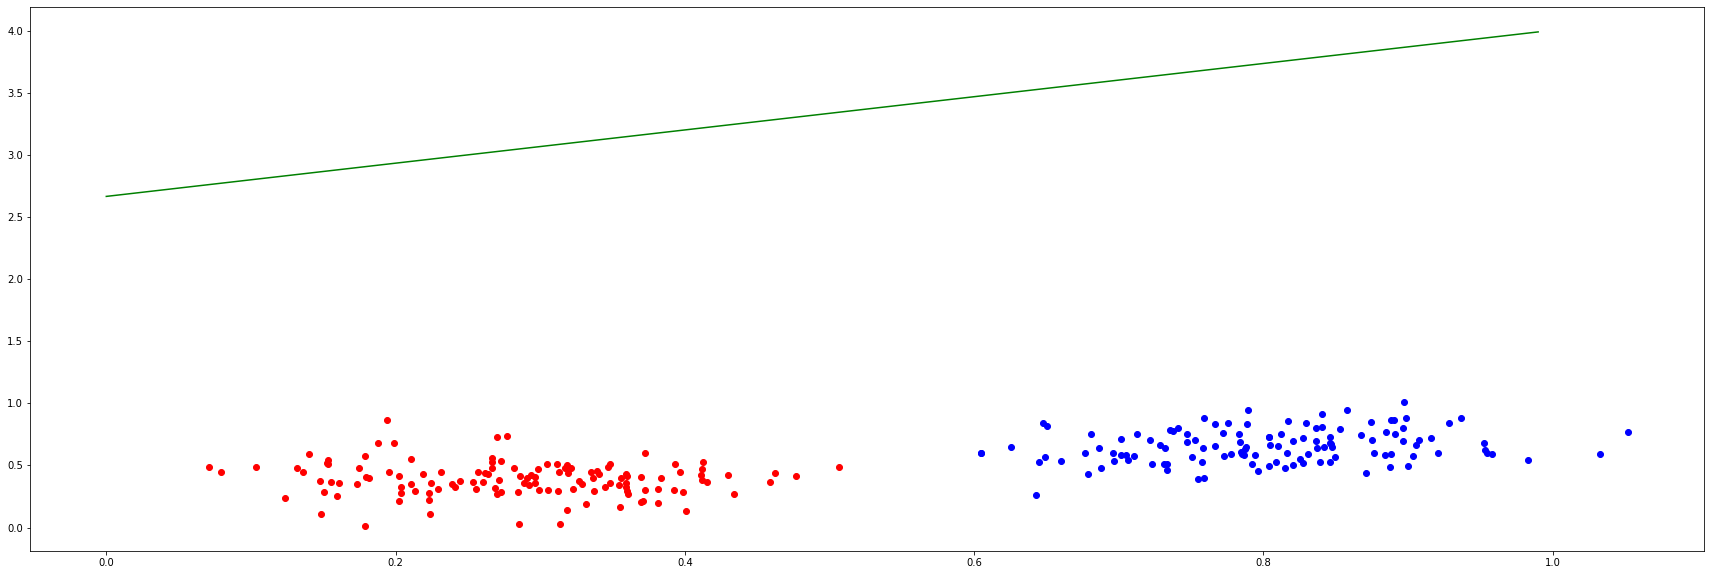

In [ ]:
print(f"Test Accuracy = {best_model.get_accuracy(y_test, best_y_preds)}\n")
best_model.plot_decision_boundary(X_test_scaled, y_test)